In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

/Users/yujian/.pyenv/versions/3.10.1/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/yujian/.pyenv/versions/3.10.1/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: /Users/yujian/.pyenv/versions/3.10.1/lib/python3.10/site-packages/torchvision/image.so
  Expected in: /Users/yujian/.pyenv/versions/3.10.1/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # self.flatten = nn.Flatten()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3), # 28 x 28 --> 26 x 26 x 4
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1), # 26 x 26 x 4 
            nn.Flatten(), # --> (26 x 26 x 4)
            nn.Linear(26*26*4, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, X):
        # x = self.flatten(X)
        logits = self.cnn(X)
        return logits
    
    # def forward(self, X):
    #     print(X.size())
    #     for layer in self.cnn:
    #         X = layer(X)
    #         print(X.size())
    #     return X

training_data = datasets.FashionMNIST(root="../fashion_mnist", train=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root="../fashion_mnist", train=False, transform=transforms.ToTensor())

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [54]:
model = NeuralNetwork()
learning_rate = 1e-3
batch_size=64
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [50]:
print(model)

NeuralNetwork(
  (cnn): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=2704, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [51]:

input = torch.stack([training_data[x][0] for x in range(0, 64)])
model(input)

torch.Size([64, 1, 28, 28])
torch.Size([64, 4, 26, 26])
torch.Size([64, 4, 26, 26])
torch.Size([64, 4, 26, 26])
torch.Size([64, 2704])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 10])


tensor([[ 3.0346e-02, -4.4125e-02,  3.0246e-02, -3.4239e-02,  1.4106e-01,
         -5.1276e-04, -9.9090e-02,  1.0239e-01, -1.0917e-01, -5.0798e-02],
        [ 5.4476e-03, -6.0326e-02,  5.5434e-03, -4.6536e-02,  1.4395e-01,
          2.5580e-02, -8.0433e-02,  3.1112e-03, -3.6385e-02, -6.3081e-02],
        [ 8.7745e-03, -6.1325e-02,  8.9097e-03, -6.6091e-02,  1.1708e-01,
          5.6031e-02, -1.1513e-01,  4.0812e-02, -3.5788e-02, -2.9226e-03],
        [ 3.8022e-02, -5.0692e-02,  1.8482e-03, -7.1349e-02,  1.2494e-01,
          2.5358e-02, -1.0813e-01,  3.1888e-02, -4.4907e-02, -2.2261e-02],
        [-1.8065e-02, -1.1054e-01,  7.3579e-03, -7.4405e-02,  1.6384e-01,
          8.5294e-02, -1.5826e-01,  2.9774e-02, -7.2252e-02, -2.6561e-03],
        [ 6.7308e-03, -8.2724e-02,  5.6795e-02, -4.7419e-02,  1.1176e-01,
          5.0351e-02, -1.2336e-01, -2.8187e-02, -6.1429e-02, -1.1596e-02],
        [ 2.8475e-02, -4.4945e-03,  5.0531e-02, -2.6639e-02,  9.7276e-02,
         -1.0868e-02, -7.9146e-0

In [34]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # predictions
        pred = model(X)
        loss = loss_fn(pred, y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch%100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Current loss: {loss:>7f}, [{current:>5d}/{size:>5d}]")

In [10]:
def test_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Error:\n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")
    return 100*correct

In [55]:
def optimize_loop(epoch_list, accuracy_list, epochs, _optimizer=optimizer):
    for t in range(epochs):
        print(f"Epoch {t+1}\n")
        train_loop(train_dataloader, model, loss_fn, optimizer = _optimizer)
        accuracy = test_loop(test_dataloader, model, loss_fn, optimizer = _optimizer)
        epoch_list.append(t)
        accuracy_list.append(accuracy)
    print("Done!")

In [56]:
import matplotlib
plot_x = [] # epoch
plot_y = [] # accuracy
optimize_loop(plot_x, plot_y, 40)

Epoch 1

Current loss: 2.306516, [    0/60000]
Current loss: 2.233973, [ 6400/60000]
Current loss: 2.146708, [12800/60000]
Current loss: 2.100178, [19200/60000]
Current loss: 2.010174, [25600/60000]
Current loss: 1.883833, [32000/60000]
Current loss: 1.832211, [38400/60000]
Current loss: 1.645493, [44800/60000]
Current loss: 1.528988, [51200/60000]
Current loss: 1.352238, [57600/60000]
Test Error:
 Accuracy: 63.4%, Avg loss: 1.339488

Epoch 2

Current loss: 1.415871, [    0/60000]
Current loss: 1.309743, [ 6400/60000]
Current loss: 1.105446, [12800/60000]
Current loss: 1.144978, [19200/60000]
Current loss: 0.997873, [25600/60000]
Current loss: 0.991498, [32000/60000]
Current loss: 0.996030, [38400/60000]
Current loss: 0.934652, [44800/60000]
Current loss: 0.941338, [51200/60000]
Current loss: 0.876024, [57600/60000]
Test Error:
 Accuracy: 68.6%, Avg loss: 0.877375

Epoch 3

Current loss: 0.909917, [    0/60000]
Current loss: 0.934800, [ 6400/60000]
Current loss: 0.711993, [12800/60000]

w/ maxpool k=3: 2048x8 --> 2^14

w/ maxpool k=2: 3328x13

w/o maxpool: 6656x26 (26 x 4 x 64)

w/ Flatten + Maxpool Kernel Size 2: turns into 64x(26x26)



In [66]:
import matplotlib.pyplot as plt

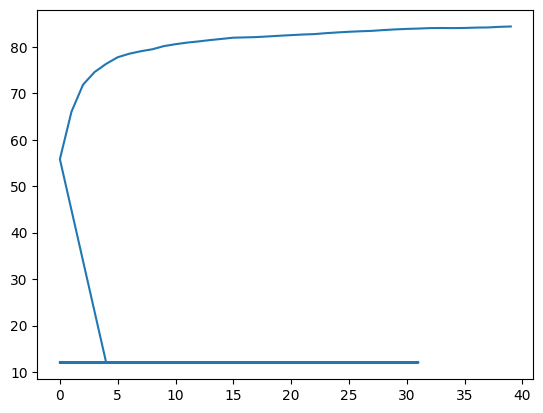

In [67]:
plt.plot(plot_x, plot_y)
plt.show()

In [69]:
plot_y

[12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 12.08,
 55.81,
 66.0,
 71.83,
 74.55000000000001,
 76.31,
 77.73,
 78.49000000000001,
 79.03,
 79.45,
 80.13,
 80.54,
 80.88,
 81.14,
 81.43,
 81.67999999999999,
 81.94,
 82.0,
 82.07,
 82.21000000000001,
 82.36,
 82.49,
 82.62,
 82.71,
 82.91,
 83.07,
 83.21,
 83.32000000000001,
 83.41,
 83.58,
 83.72,
 83.83,
 83.89999999999999,
 84.0,
 84.02,
 84.0,
 84.03,
 84.11,
 84.14,
 84.27,
 84.35000000000001]